# Ising model

Here we consider inference on an Ising model.
First we import the code and set some plotting parameters.

In [648]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys,time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from gibbs import *
from concrete import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

## 1D model

The one dimensional Ising model considers a target distribution $\pi(x)$
on $\mathcal{X}=\{-1,1\}^M$ such that
$$
    \pi(x)\propto\exp\left\{\beta\sum_{m=1}^{M-1} x_m x_{m+1}\right\},
$$
where $\beta>0$ is a temperature parameter.
The normalizing constant is intractable since it involves a sum over $2^M$ terms
but the full conditionals $\pi_m$ can be calculated in closed form.
Specifically, for the particles $x_1$ and $x_M$ the full conditional
only depends on their only neighbors:
$$
    \pi_1(x)=\frac{\exp(x x_2)}{2\cosh(1)},\qquad
    \pi_M(x)=\frac{\exp(x x_{M-1})}{2\cosh(1)}.
$$
The normalizing constant is tractable since it involves adding over two terms only
and can be simplified since $\cosh(1)=\cosh(-1)$.
The probability for particles with two neighbors 
$x_m,  m\neq1,M$ is likewise given by
$$
    \pi_m(x)=\frac{\exp(x (x_{m-1} + x_{m+1}))}{2\cosh(x_{m-1}+x_{m+1})}.
$$

We consider an instantiation with $M=5$ particles
that starts at a uniform distribution over the $2^M$ possible arrangements.

In [649]:
########################
########################
# target specification #
########################
########################
M=5 # number of particles

# target
beta=1. # inverse temperature
logZ1=np.log(2*np.cosh(beta)) # same for any value of x_2 and x_(M-1)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: 
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        return beta*np.sum(tmp_x*lag_x,axis=0)
    if axis==0: return np.vstack((-xc[1,:],xc[1,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis+1,:]))
    if axis==M-1: return np.vstack((-xc[-2,:],xc[-2,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis-1,:]))
    if axis>=M: raise Exception("Axis out of bounds")
    logZm=np.log(2*np.cosh(beta*(xc[axis-1,:]+xc[axis+1,:])))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:],xc[axis-1,:]+xc[axis+1,:])).T-logZm[:,np.newaxis]

In [650]:
x=idx_unflattenBinary(np.arange(0,2**M),M)
lprbs=lp(x)
prbs=np.exp(lprbs)
prbs=prbs/np.sum(prbs)

In [651]:
########################
########################
#    Mad Mix approx    #
########################
########################
# reference specification
lq0 = lambda x,u : -M*np.log(2)*np.ones(x.shape[1])
def randq0(size): 
    tmpx=np.random.randint(low=0,high=2,size=(M,size))
    return tmpx,np.random.rand(M,size)

# settings
N=100
n_samples=1000
xi=np.pi/16
x=idx_unflattenBinary(np.arange(0,2**M),M)

In [652]:
qvar=np.exp(lqN(x,np.random.rand(M,2**M),N=N,lq0=lq0,lp=lp,xi=xi))

In [653]:
# compute ELBO
elbo_qN=elbo_exact(np.log(qvar/np.sum(qvar)),np.log(prbs))

In [654]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
x0=np.random.randint(low=0,high=2,size=M)
gibbs_samples=gibbs_sampler(x0=x0,steps=n_samples,lp=lp,burnin_pct=0.95,verbose=True)

In [655]:
# get density and compute ELBO
gibbs_density=plt.hist(idx_flattenBinary(gibbs_samples),bins=np.arange(0,2**M+1),density=True)[0]
gibbs_density[gibbs_density<1e-32]=1e-32
gibbs_density=gibbs_density/np.sum(gibbs_density)
plt.clf()
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))

<Figure size 1500x750 with 0 Axes>

In [656]:
########################
########################
#    Concrete          #
########################
########################
from IPython.display import clear_output
RUN=True # ONLY TRUE IF YOU WANT TO RERUN RESULTS

# TIME SUNK!!! RUN AT YOUR OWN PERIL
# simulation settings:
max_iters = 10001
temps     = np.array([0.1,0.5,1,5])
depths    = np.array([10,50,100])
layers    = np.array([32,64,128,256])
sim_size  = temps.shape[0]*depths.shape[0]*layers.shape[0]
if RUN:
    # redefine arrays only if running from scratch
    flows     = [0 for i in range(sim_size)]
    losses    = np.zeros((sim_size,max_iters))
    cpu_times = np.zeros(sim_size)

i=0
print('Training '+str(sim_size)+' flows')
for temp in temps:
    if not RUN: continue
    for depth in depths:
        for width in layers:
            print('Training flow '+str(i+1)+'/'+str(sim_size))
            print('Temperature: '+str(temp))
            print('Depth: '+str(depth))
            print('Width: '+str(width))
            t0 = time.perf_counter()
            tmp_flow,tmp_loss=trainRealNVP(
                temp=temp,depth=depth,lprbs=np.log(est_prbs).flatten(),layers=width,max_iters=max_iters,lr=1e-3,seed=2023
            )
            cpu_times[i]=time.perf_counter()-t0
            flows[i]=tmp_flow
            losses[i,:]=tmp_loss
            clear_output(wait=True)
            i=i+1
        # end for
    # end for
# end for
clear_output(wait=True)
print('Done!')
print('Total training time: '+str(cpu_times.sum())+' seconds')

Done!
Total training time: 31957.436193790883 seconds


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

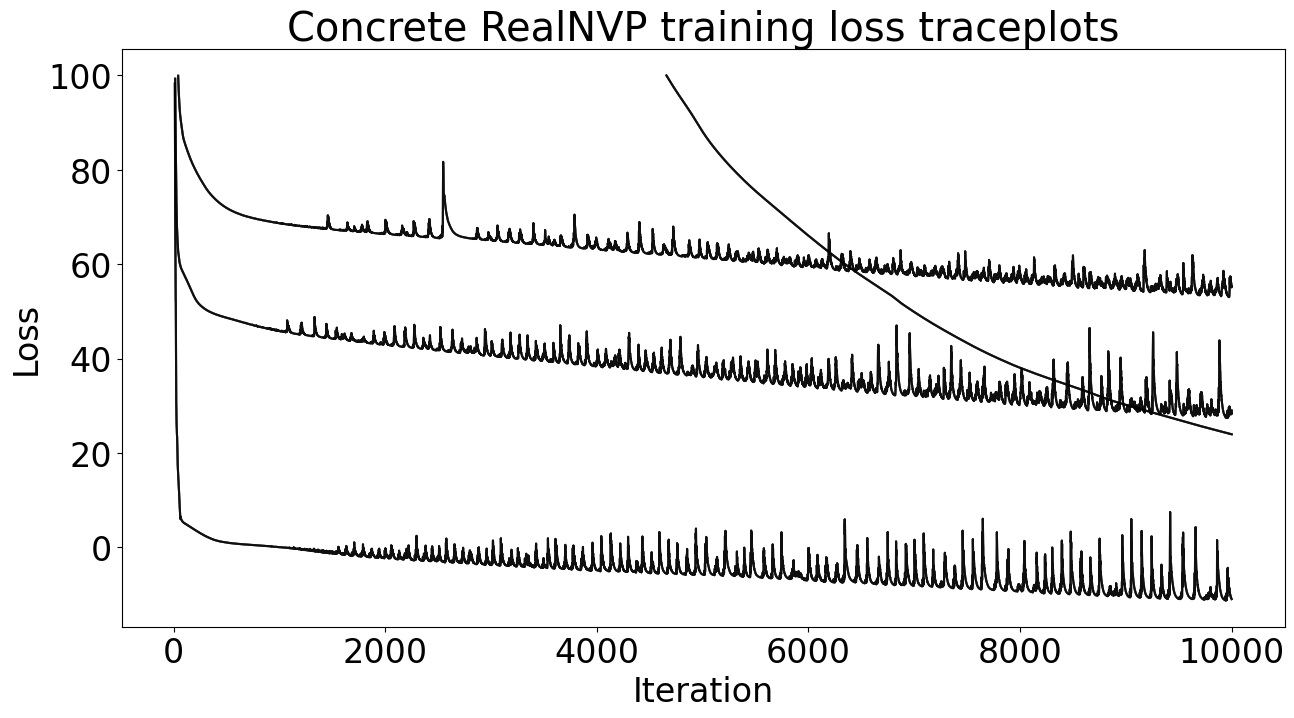

In [657]:
# loss traceplot
threshold=100
for i in range(sim_size): plt.plot(np.arange(max_iters)[losses[i,:]<threshold],losses[i,losses[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [658]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
samples=np.zeros((sim_size,M,sample_size))
densities=np.zeros((sim_size,2**M))
elbos=np.zeros(sim_size)

for i in range(sim_size):
    print(str(i+1)+'/'+str(sim_size),end='\r')
    tmp_flow=flows[i]
    
    # generate sample
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
    tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs
    tmp_sample=np.argmax(tmp_sample,axis=-1) # rounding Concrete
    tmp_sample=idx_unflattenBinary(tmp_sample,M) # 1d->2d
    samples[i,:,:]=tmp_sample
    
    # compute freq density
    tmp_density=plt.hist(idx_flattenBinary(tmp_sample),bins=np.arange(0,2**M+1),density=True)[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    tmp_density=tmp_density/np.sum(tmp_density)
    densities[i,:]=tmp_density
    
    # estimate elbo
    elbos[i]=elbo_exact(np.log(tmp_density),np.log(prbs))
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_97142/1207522220.py:18: RuntimeWarning: overflow encountered in exp
  tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_97142/1207522220.py:19: RuntimeWarning: invalid value encountered in divide
  tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs


<Figure size 1500x750 with 0 Axes>

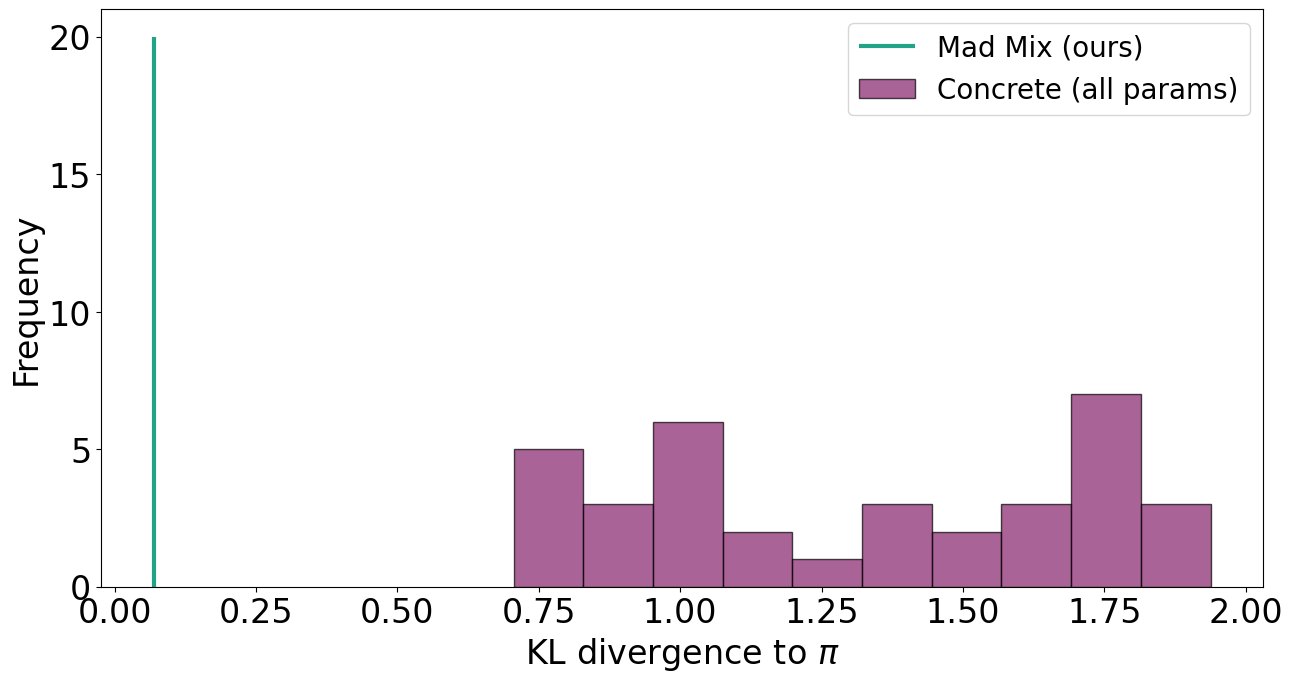

In [659]:
plt.vlines(-elbo_qN,ymin=0,ymax=20,colors='#20A386FF',lw=3,label='Mad Mix (ours)')
#plt.vlines(-elbo_gibbs,ymin=0,ymax=20,colors='#FBB91FFF',lw=1.5,label='Gibbs',alpha=0.8)
plt.hist(-elbos[-elbos<2],bins=10,color='#87216BFF',ec='black',alpha=0.7,label='Concrete (all params)') #taking out elbo<-2
plt.xlabel(r'KL divergence to $\pi$')
plt.ylabel('Frequency')
plt.legend(fontsize='small')

Text(0, 0.5, 'probability')

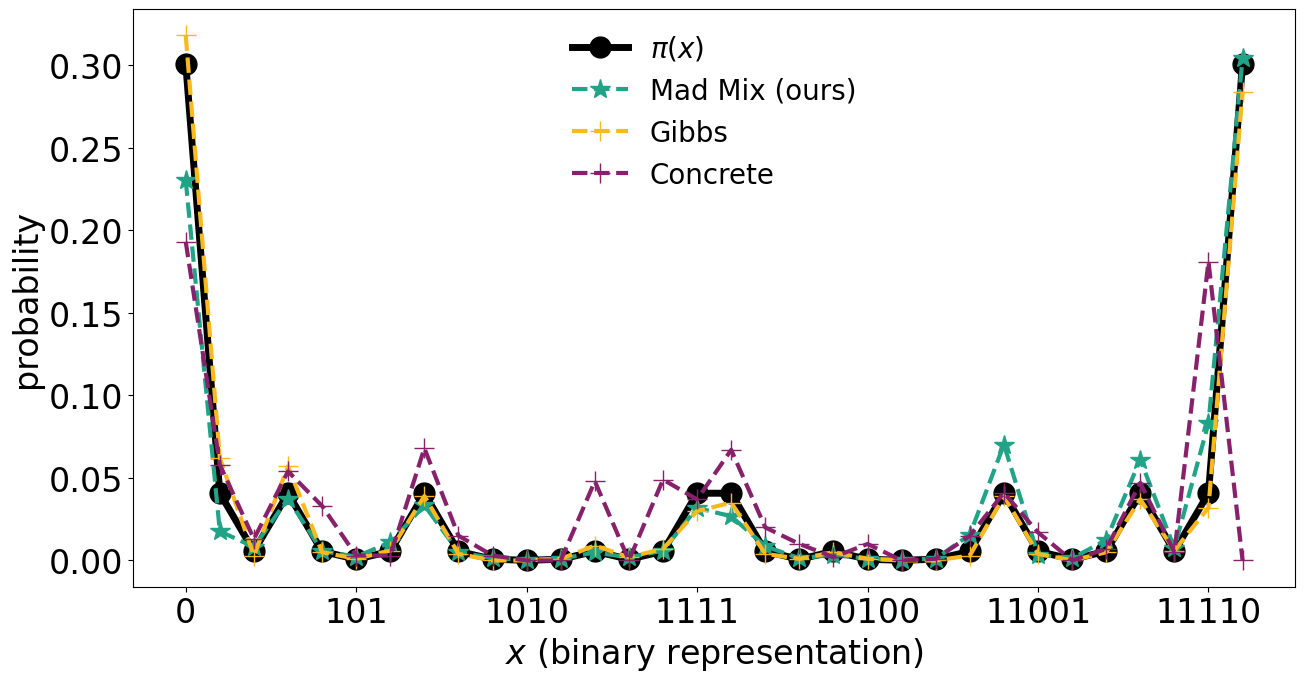

In [660]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,2**M)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,qvar/np.sum(qvar),c='#20A386FF', label='Mad Mix (ours)',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,gibbs_density,c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,densities[np.argmax(elbos),:],c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$x$ (binary representation)')
plt.xticks(ticks=np.arange(0,2**M,step=M)+0.5,labels=[np.binary_repr(t) for t in np.arange(0,2**M,step=M)])
plt.ylabel('probability')

In [661]:
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))
print('ELBO(qConcrete_opt||π)='+str(elbos[np.argmax(elbos)]))

ELBO(qN||π)=-0.06935328291580316
ELBO(qGibbs||π)=-0.018472221891704724
ELBO(qConcrete_opt||π)=-0.705661012311941


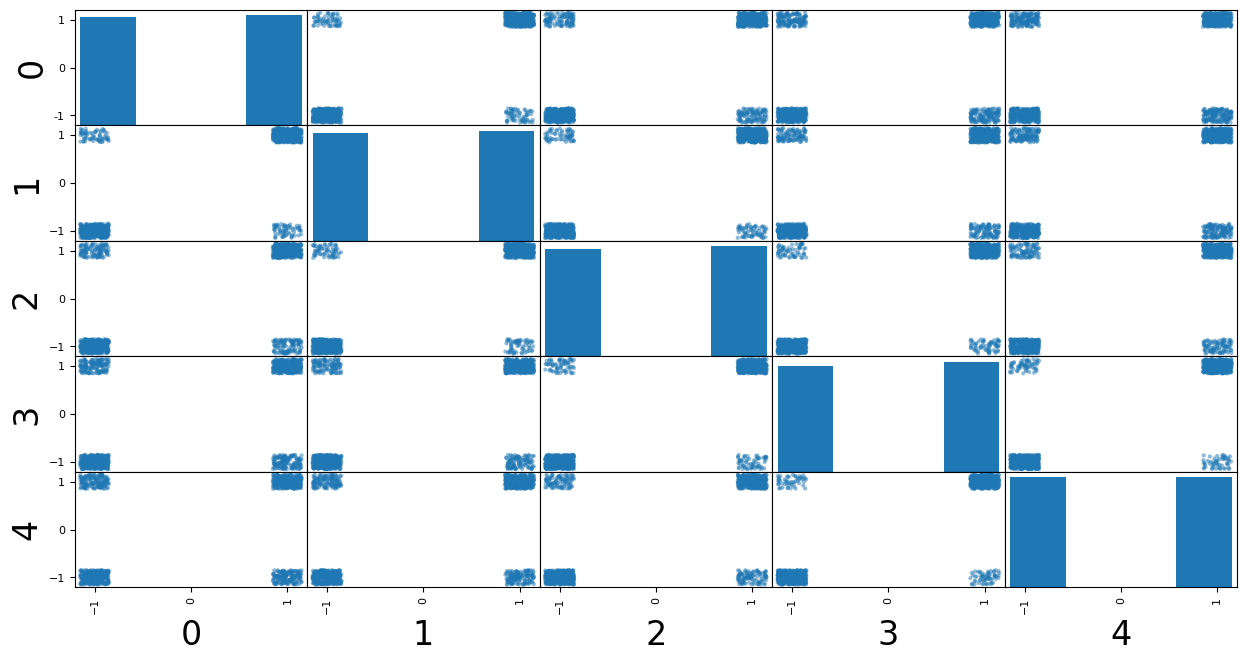

In [662]:
jit=0.3 # to jitter scatterplot
xcsamples=2.*xsamples-1. # to transform back to -1,1
for m in range(M): xcsamples[m,:]=xcsamples[m,:]+jit*np.random.rand(xcsamples.shape[1])-0.5*jit
df = pd.DataFrame(xcsamples.T)
axes = pd.plotting.scatter_matrix(df, alpha=0.5,hist_kwds={'bins': 4})

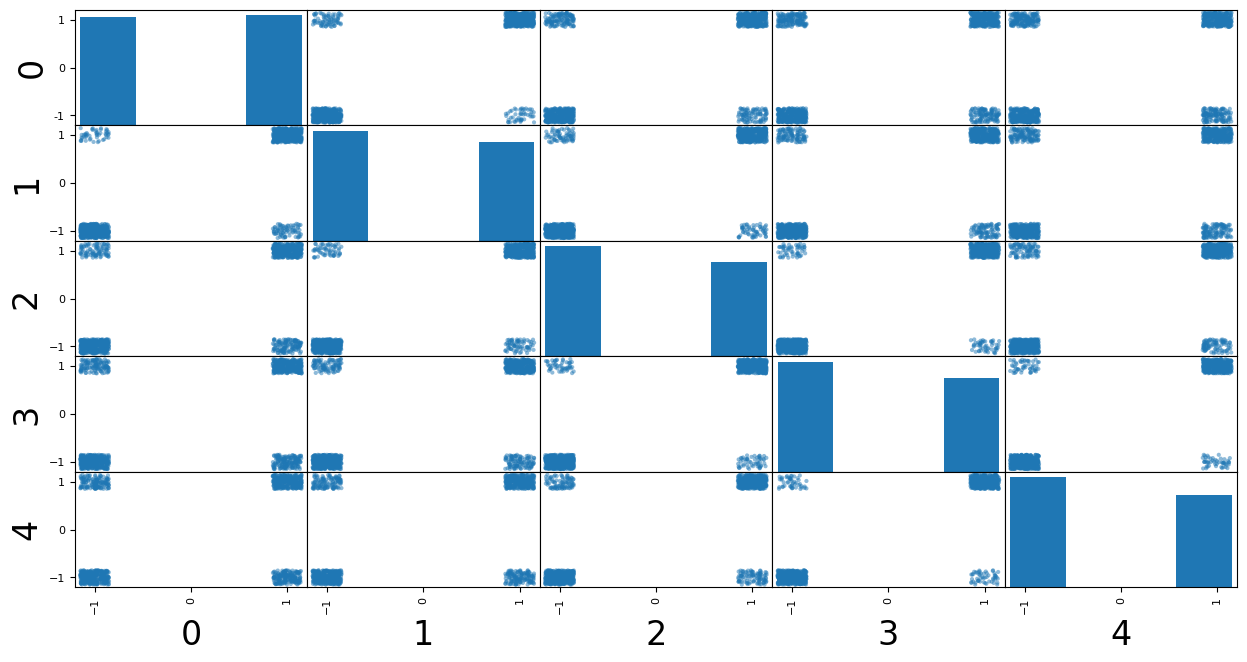

In [663]:
jit=0.3 # to jitter scatterplot
gibbscsamples=2.*gibbs_samples-1. # to transform back to -1,1
for m in range(M): gibbscsamples[m,:]=gibbscsamples[m,:]+jit*np.random.rand(gibbscsamples.shape[1])-0.5*jit
df = pd.DataFrame(gibbscsamples.T)
axes = pd.plotting.scatter_matrix(df, alpha=0.5,hist_kwds={'bins': 4})

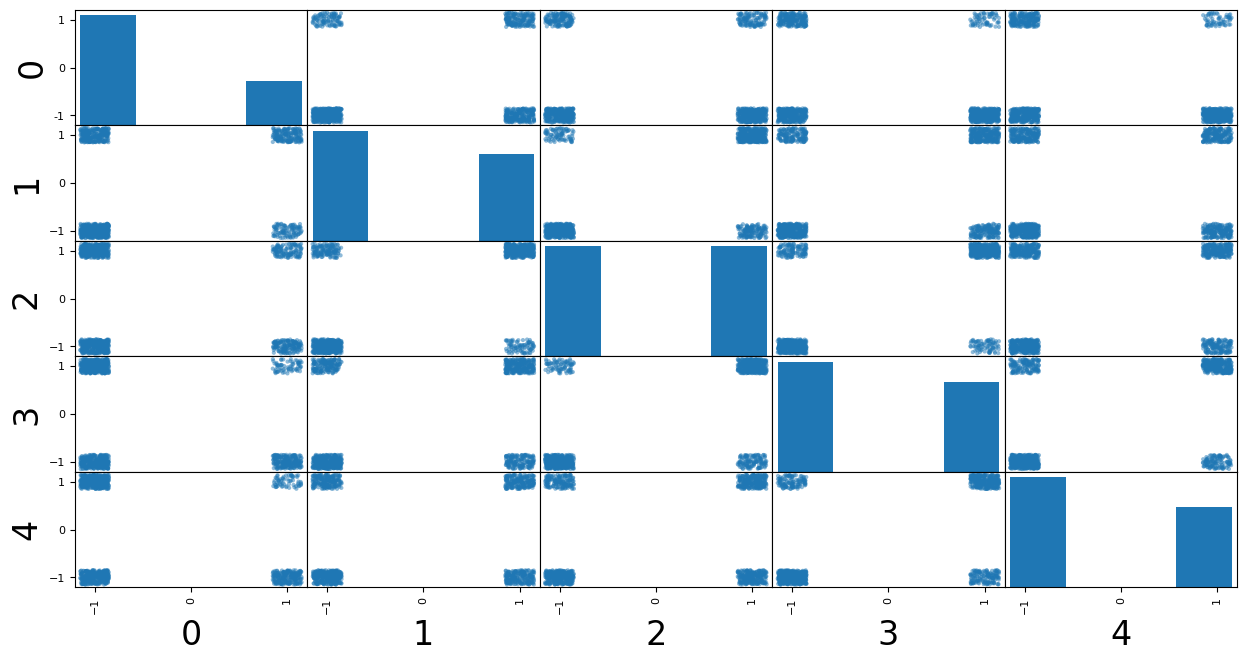

In [665]:
jit=0.3 # to jitter scatterplot
concretecsamples=2.*samples-1. # to transform back to -1,1
for m in range(M): concretecsamples[np.argmax(elbos),m,:]=concretecsamples[np.argmax(elbos),m,:]+jit*np.random.rand(concretecsamples.shape[-1])-0.5*jit
df = pd.DataFrame(concretecsamples[np.argmax(elbos),:,:].T)
axes = pd.plotting.scatter_matrix(df, alpha=0.5,hist_kwds={'bins': 4})

# 1D Ising with a large M

In [666]:
########################
########################
# target specification #
########################
########################
M=12 # number of particles

# target
beta=2. # temperature
logZ1=np.log(2*np.cosh(beta)) # same for any value of x_2 and x_(M-1)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: 
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        return beta*np.sum(tmp_x*lag_x,axis=0)
    if axis==0: return np.vstack((-xc[1,:],xc[1,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis+1,:]))
    if axis==M-1: return np.vstack((-xc[-2,:],xc[-2,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis-1,:]))
    if axis>=M: raise Exception("Axis out of bounds")
    logZm=np.log(2*np.cosh(beta*(xc[axis-1,:]+xc[axis+1,:])))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:],xc[axis-1,:]+xc[axis+1,:])).T-logZm[:,np.newaxis]

In [667]:
x=idx_unflattenBinary(np.arange(0,2**M),M)
lprbs=lp(x)
prbs=np.exp(lprbs)
prbs=prbs/np.sum(prbs)

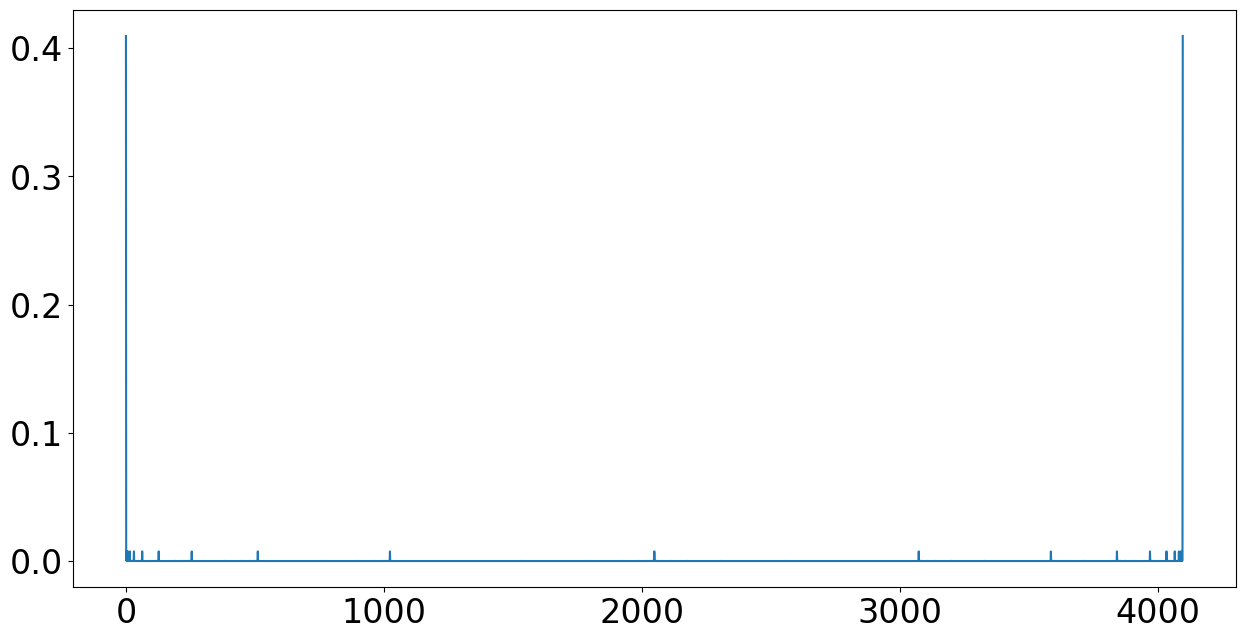

In [668]:
plt.plot(np.arange(0,2**M),prbs)

## KL-optimal weighting

In [669]:
###############################
###############################
# variational family settings #
###############################
###############################
np.random.seed(1)
# reference specification
poiss_lambda=1.
p0=stats.poisson.pmf(np.arange(0,2**M),mu=poiss_lambda) # assign probs close to all 0's
p0[p0<0.05]=1e-64
p0=p0/np.sum(p0)
p1=np.flip(p0) # assign probs close to all 1's
lq0_0 = lambda x,u : np.log(p0[idx_flattenBinary(x)])
lq0_1 = lambda x,u : np.log(p1[idx_flattenBinary(x)])

def randq0_0(size): 
    return idx_unflattenBinary(np.random.choice(a=np.arange(0,2**M),size=size,p=p0),M),np.random.rand(M,size)
def randq0_1(size): 
    return idx_unflattenBinary(np.random.choice(a=np.arange(0,2**M),size=size,p=p1),M),np.random.rand(M,size)

# settings
N0=3
N1=4
xi=np.pi/16

# mixture variational approximation
fixed_u=np.random.rand(M,2**M)
lq0 = lambda x : lqN(x,fixed_u,N0,lq0_0,lp,xi)
lq1 = lambda x : lqN(x,fixed_u,N1,lq0_1,lp,xi)
def lq(x,w):
    exp1=lq0(x)+np.log(w)
    exp2=lq1(x)+np.log1p(-w)
    m=np.maximum(exp1,exp2)
    return m+np.log(np.exp(exp1-m)+np.exp(exp2-m))
def lq_fixed(w):
    exp1=lq0_fixed+np.log(w)
    exp2=lq1_fixed+np.log1p(-w)
    m=np.maximum(exp1,exp2)
    return m+np.log(np.exp(exp1-m)+np.exp(exp2-m))

# init x grid and fixed densities
x=idx_unflattenBinary(np.arange(0,2**M),M)
lq0_fixed=lq0(idx_unflattenBinary(np.arange(0,2**M),M))
#lq1_fixed=lq1(idx_unflattenBinary(np.arange(0,2**M),M))

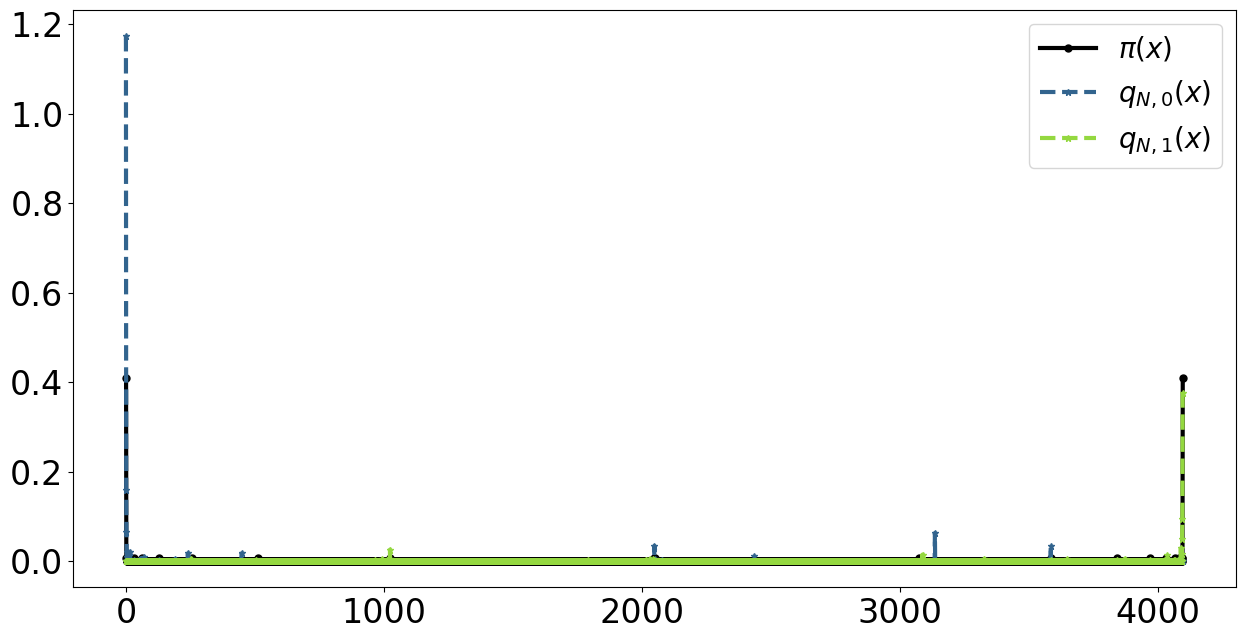

In [670]:
ttx=np.arange(0,2**M)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=3,ms=5,marker='o')
plt.plot(np.arange(0,2**M),np.exp(lq0_fixed),c='#32648EFF', label=r'$q_{N,0}(x)$',lw=3,ls='dashed',ms=5,marker='*')
plt.plot(np.arange(0,2**M),np.exp(lq1_fixed),c='#94D840FF', label=r'$q_{N,1}(x)$',lw=3,ls='dashed',ms=5,marker='*')
plt.legend(fontsize='small')

In [671]:
######################
######################
#    optimization    #
######################
######################

# optimization settings
np.random.seed(2023)
max_iter=1001
gamma=1e-1
w=np.random.rand()
print('Initial w: '+str(w))
print()
print('Iter  |          w          |   gradient')

for t in range(max_iter):
    #gradient=np.sum((np.exp(lq0_fixed)-np.exp(lq1_fixed))*(lq(x,w)-lp(x))) # unfixed x
    gradient=np.sum((np.exp(lq0_fixed)-np.exp(lq1_fixed))*(lq_fixed(w)-np.log(prbs))) # with fixed x
    w=w-gradient*gamma/np.sqrt(t+1)
    w=min(1-1e-16,max(1e-16,w)) # constrain to (0,1)
    if t%(max_iter//10)==0: print('  '+str(t)+'   | '+str(w)+'  | '+str(gradient))
# end for

Initial w: 0.32198830399196776

Iter  |          w          |   gradient
  0   | 0.2598012275825798  | 0.6218707640938795
  100   | 0.23479429860939388  | 2.268093907131785e-08
  200   | 0.2347942960557252  | 2.1031509866986653e-11
  300   | 0.23479429605330612  | 1.0313971898767704e-13
  400   | 0.23479429605329438  | 2.4980018054066022e-15
  500   | 0.23479429605329438  | 2.4980018054066022e-15
  600   | 0.23479429605329438  | 2.4980018054066022e-15
  700   | 0.23479429605329438  | 2.4980018054066022e-15
  800   | 0.23479429605329438  | 2.4980018054066022e-15
  900   | 0.23479429605329438  | 2.4980018054066022e-15
  1000   | 0.23479429605329438  | 2.4980018054066022e-15


In [672]:
#weighted_q=np.exp(lq(x,w))
weighted_q=np.exp(lq_fixed(w))

In [673]:
# compute ELBO
elbo_qN=elbo_exact(np.log(weighted_q/np.sum(weighted_q)),np.log(prbs))

In [674]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
n_samples=1000
x0=np.random.randint(low=0,high=2,size=M)
gibbs_samples=gibbs_sampler(x0=x0,steps=n_samples,lp=lp,burnin_pct=0.25,verbose=True)

In [675]:
# get density and compute ELBO
gibbs_density=plt.hist(idx_flattenBinary(gibbs_samples),bins=np.arange(0,2**M+1),density=True)[0]
gibbs_density[gibbs_density<1e-32]=1e-32
gibbs_density=gibbs_density/np.sum(gibbs_density)
plt.clf()
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))

<Figure size 1500x750 with 0 Axes>

In [676]:
########################
########################
#    Concrete          #
########################
########################
from IPython.display import clear_output
RUN=False # ONLY TRUE IF YOU WANT TO RERUN RESULTS

# TIME SUNK!!! RUN AT YOUR OWN PERIL
# simulation settings:
max_iters = 10001
temps     = np.array([0.1,0.5,1,5])
depths    = np.array([10,50,100])
layers    = np.array([32,64,128,256])
sim_size  = temps.shape[0]*depths.shape[0]*layers.shape[0]
if RUN:
    # redefine arrays only if running from scratch
    flowsM     = [0 for i in range(sim_size)]
    lossesM    = np.zeros((sim_size,max_iters))
    cpu_timesM = np.zeros(sim_size)

i=0
print('Training '+str(sim_size)+' flows')
for temp in temps:
    if not RUN: continue
    for depth in depths:
        for width in layers:
            print('Training flow '+str(i+1)+'/'+str(sim_size))
            print('Temperature: '+str(temp))
            print('Depth: '+str(depth))
            print('Width: '+str(width))
            t0 = time.perf_counter()
            tmp_flow,tmp_loss=trainRealNVP(
                temp=temp,depth=depth,lprbs=np.log(est_prbs).flatten(),layers=width,max_iters=max_iters,lr=1e-3,seed=2023
            )
            cpu_timesM[i]=time.perf_counter()-t0
            flowsM[i]=tmp_flow
            lossesM[i,:]=tmp_loss
            clear_output(wait=True)
            i=i+1
        # end for
    # end for
# end for
clear_output(wait=True)
print('Done!')
print('Total training time: '+str(cpu_timesM.sum())+' seconds')

Done!
Total training time: 31322.71626633199 seconds


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

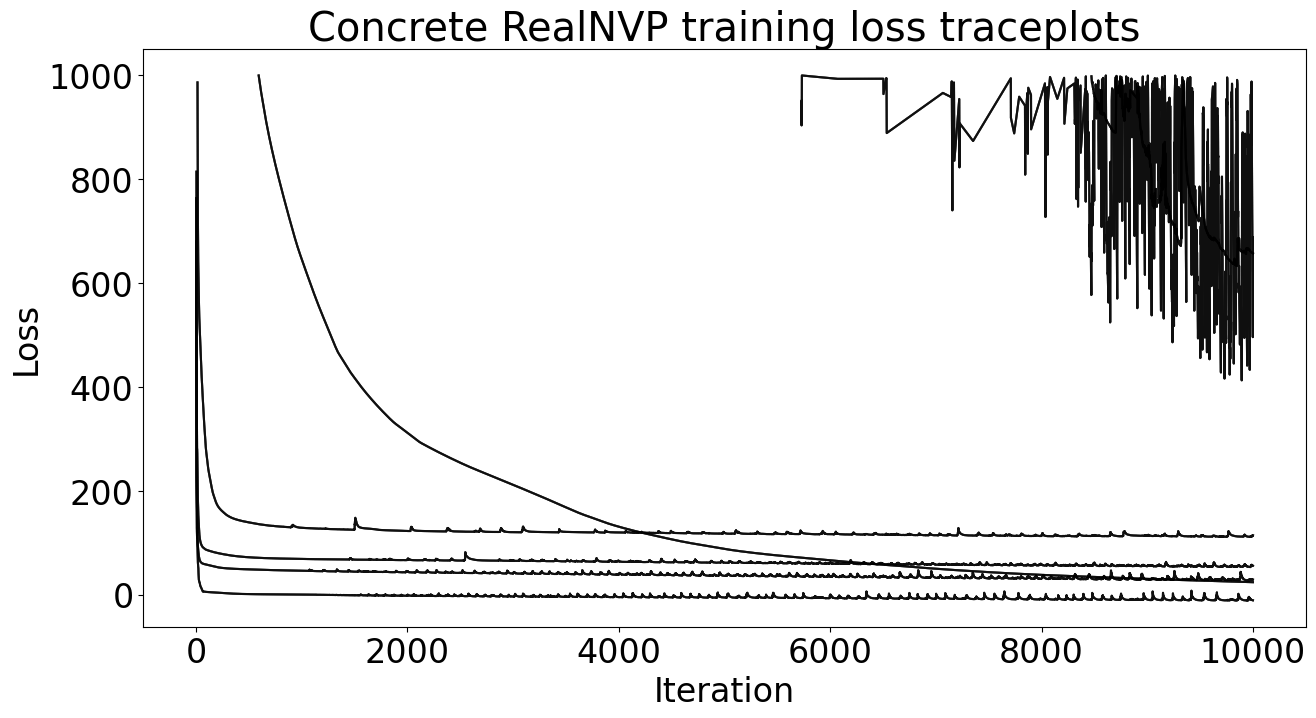

In [677]:
# loss traceplot
threshold=1000
for i in range(sim_size): plt.plot(np.arange(max_iters)[lossesM[i,:]<threshold],lossesM[i,lossesM[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [678]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
samplesM=np.zeros((sim_size,M,sample_size))
densitiesM=np.zeros((sim_size,2**M))
elbosM=np.zeros(sim_size)

for i in range(sim_size):
    print(str(i+1)+'/'+str(sim_size),end='\r')
    tmp_flow=flowsM[i]
    
    # generate sample
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
    tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs
    tmp_sample=np.argmax(tmp_sample,axis=-1) # rounding Concrete
    tmp_sample=idx_unflattenBinary(tmp_sample,M) # 1d->2d
    samplesM[i,:,:]=tmp_sample
    
    # compute freq density
    tmp_density=plt.hist(idx_flattenBinary(tmp_sample),bins=np.arange(0,2**M+1),density=True)[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    tmp_density=tmp_density/np.sum(tmp_density)
    densitiesM[i,:]=tmp_density
    
    # estimate elbo
    elbosM[i]=elbo_exact(np.log(tmp_density),np.log(prbs))
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_97142/3508441580.py:18: RuntimeWarning: overflow encountered in exp
  tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_97142/3508441580.py:19: RuntimeWarning: invalid value encountered in divide
  tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs


<Figure size 1500x750 with 0 Axes>

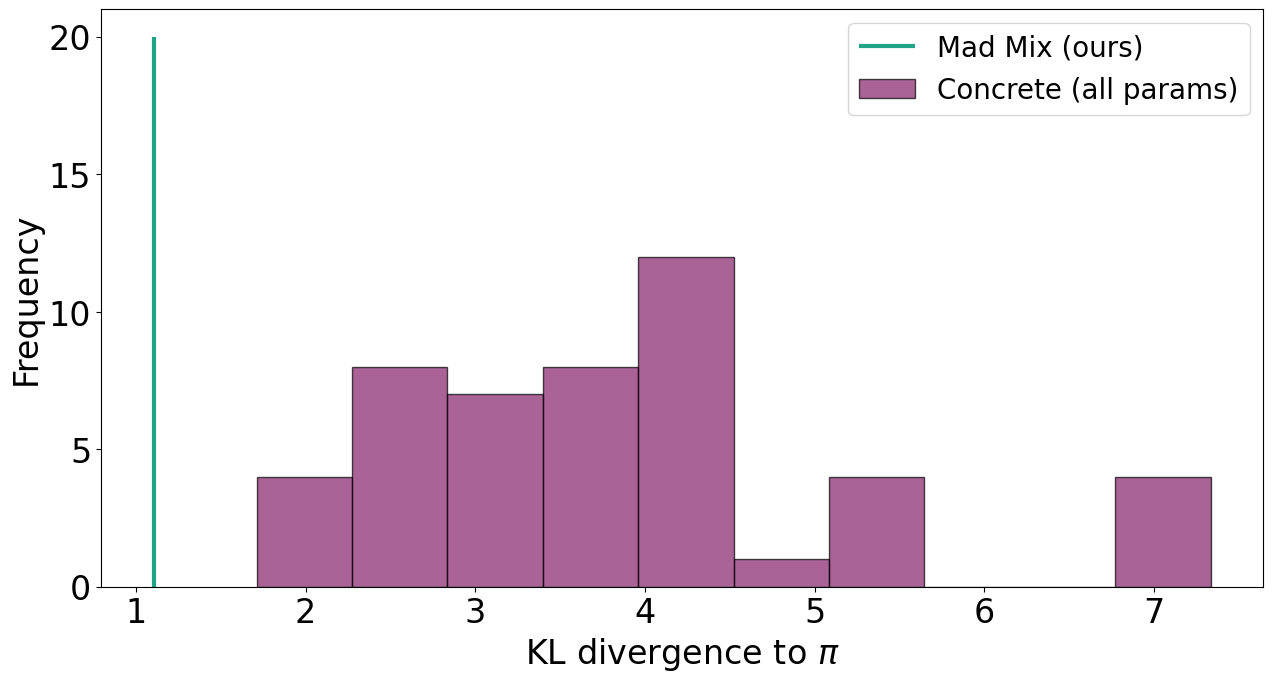

In [679]:
plt.vlines(-elbo_qN,ymin=0,ymax=20,colors='#20A386FF',lw=3,label='Mad Mix (ours)')
#plt.vlines(-elbo_gibbs,ymin=0,ymax=20,colors='#FBB91FFF',lw=1.5,label='Gibbs',alpha=0.8)
plt.hist(-elbosM,bins=10,color='#87216BFF',ec='black',alpha=0.7,label='Concrete (all params)') #taking out elbo<-2
plt.xlabel(r'KL divergence to $\pi$')
plt.ylabel('Frequency')
plt.legend(fontsize='small')

Text(0, 0.5, 'probability')

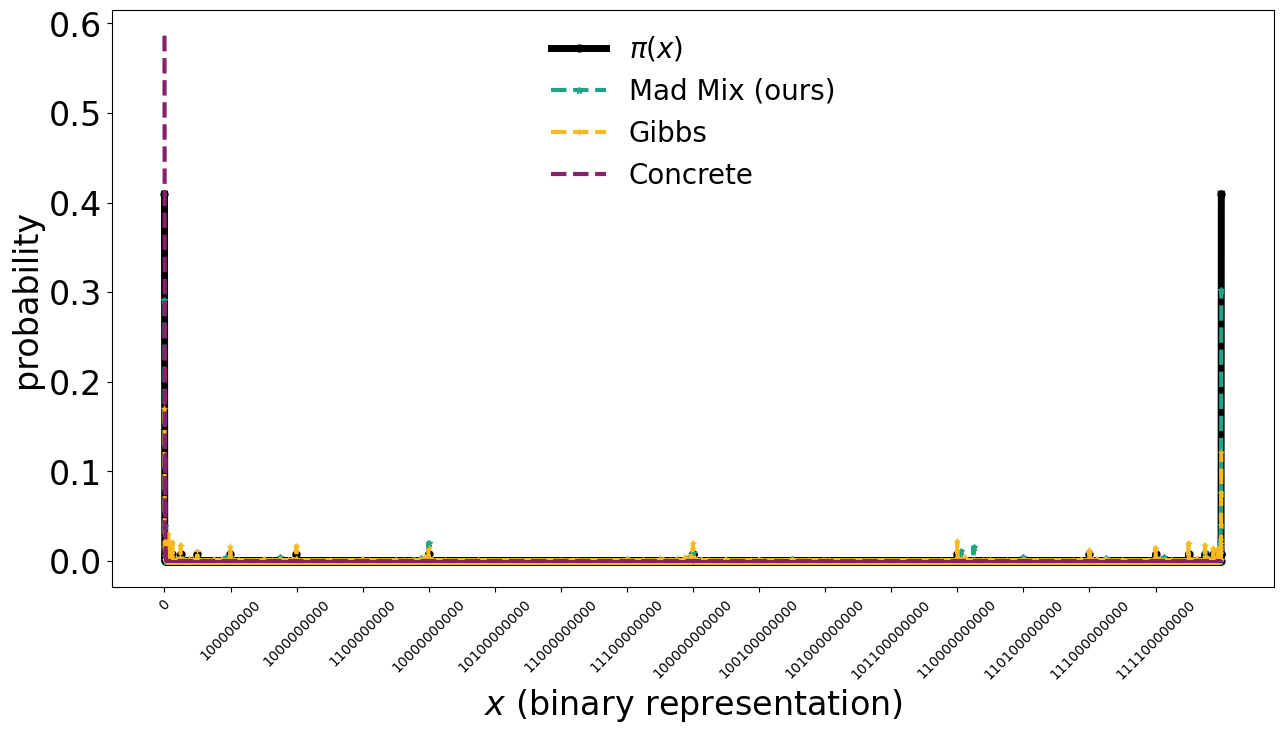

In [680]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,2**M)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=5,ms=5,marker='o')
plt.plot(ttx+0.5,weighted_q/np.sum(weighted_q),c='#20A386FF', label='Mad Mix (ours)',lw=3,ls='dashed',ms=5,marker='*')
plt.plot(ttx+0.5,gibbs_density,c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=5,marker='+')
plt.plot(ttx+0.5,densitiesM[np.argmax(elbosM),:],c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=1,marker='+')
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$x$ (binary representation)')
plt.xticks(ticks=np.arange(0,2**M,step=2**(M-4))+0.5,
           labels=[np.binary_repr(t) for t in np.arange(0,2**M,step=2**(M-4))],
          rotation=45,
          fontsize=10)
plt.ylabel('probability')

In [681]:
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))
print('ELBO(qConcrete_opt||π)='+str(elbosM[np.argmax(elbosM)]))

ELBO(qN||π)=-1.1046678345770928
ELBO(qGibbs||π)=-1.4144820292772442
ELBO(qConcrete_opt||π)=-1.7112360917322182


## 1D Ising model with observations

We now take the target $\pi(x)$ from before to be the prior distribution,
and assume we have access to $M$ observations $y_1,\dots,y_M$
that are conditionally independent given $X$.
Specifically, the likelihood is
$$
    L(y\,|\,x)=\prod_{m=1}^M \pi(y_m\,|\,x_m).
$$
The new target is then the posterior distribution
$$
    \pi(x\,|\,y)\propto
    \exp\left\{\sum_{m=1}^{M-1}x_m x_{m+1}\right\}
    \prod_{m=1}^M \pi(y_m\,|\,x_m)
    =\exp\left\{\sum_{m=1}^{M-1}x_m x_{m+1}+\log\pi(y_m\,|\,x_m)\right\}.
$$
As before, the normalization constant is intractable but the full conditionals
can be found in closed form. 
For particles not in the edges, for example,
$$
        \pi_m(x)=\frac{\exp(x(x_{m-1}+x_{m+1})+\log\pi(y_m\,|\,x))}{Z_m},
$$
where
$$
    Z_m=\exp(x_{m-1}+x_{m+1}+\log\pi(y_m\,|\,x=1))+\exp(-x_{m-1}-x_{m+1}+\log\pi(y_m\,|\,x=-1)).
$$
Edge particles are analogous but contain fewer terms since they only have one neighbor.

**Can we create observations that induce multimodality in the posterior?**
Consider, for example, a model such that $y$ is either 0 or 1 (with equal probability)
when $x=-1$ and $y$ is either 1 or 2 (again with equal probability)
when $x=+1$. Formally,
$$
    \pi(y\,|\,x)=
    \begin{cases}
    0.5,& x=-1 \text{ and } y\in\{0,1\},\\
    0.5,& x=+1 \text{ and } y\in\{1,2\},\\
    0,&\text{otherwise}
    \end{cases}.
$$
Then if we observe $M-1$ 0's and a 1, $y=(0,\dots,0,1)$,
we know that $x_1=\cdots=x_{M-1}=-1$,
but $x_M$ can be either -1 or +1.


In [ ]:
#######################
#######################
# model specification #
#######################
#######################
M=5 # number of particles

# data
y_obs=np.zeros(M)
y_obs[-1]=1

# likelihood
def ll(x,axis=None):
    # compute the log likelihood of the Ising model observations
    #
    # inputs:
    #    x    : (M,d) array with state values if axis is None, 
    #            (d,) array with mth state values if axis=m
    # outputs:
    #   ll    : (d,) array with log likelihoods
    
    if axis==None: 
        tmpy=np.repeat(y_obs[:,np.newaxis],x.shape[1],axis=1) # to match x shape
        out=np.log(0.5)*np.ones(x.shape)
        out[(x==-1) & (tmpy==2)]=np.log(1e-32) # impossible combo
        out[(x==1) & (tmpy==0)]=np.log(1e-32)  # impossible combo
        return np.sum(out,axis=0)
    
    # seems like repeated code but arrays below are (d,) dim, not (M,d) dim
    tmpy=y_obs[axis]*np.ones(x.shape)
    out=np.log(0.5)*np.ones(x.shape)
    out[(x==-1) & (tmpy==2)]=np.log(1e-32) # impossible combo
    out[(x==1) & (tmpy==0)]=np.log(1e-32)  # impossible combo
    return out

# target
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: # posterior log joint
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        lpx=np.sum(tmp_x*lag_x,axis=0)
        return lpx+ll(xc,axis=None)
    
    if axis==0: 
        ll0=ll(np.zeros(xc.shape[1])-1,axis=0)
        ll1=ll(np.ones(xc.shape[1]),axis=0)
        logZ=np.log(np.exp(-xc[1,:]+ll0)+np.exp(xc[1,:]+ll1))
        return np.vstack((-xc[1,:]+ll0,xc[1,:]+ll1)).T-logZ[:,np.newaxis]
    if axis==M-1: 
        ll0=ll(np.zeros(xc.shape[1])-1,axis=M-1)
        ll1=ll(np.ones(xc.shape[1]),axis=M-1)
        logZ=np.log(np.exp(-xc[-2,:]+ll0)+np.exp(xc[-2,:]+ll1))
        return np.vstack((-xc[-2,:]+ll0,xc[-2,:]+ll1)).T-logZ[:,np.newaxis]
    if axis>=M: raise Exception("Axis out of bounds")
    ll0=ll(np.zeros(xc.shape[1])-1,axis=axis)
    ll1=ll(np.ones(xc.shape[1]),axis=axis)
    logZ=np.log(np.exp(-xc[axis-1,:]-xc[axis+1,:]+ll0)+\
                np.exp(xc[axis-1,:]+xc[axis+1,:]+ll1))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:]+ll0,\
                      xc[axis-1,:]+xc[axis+1,:]+ll1)).T-logZ[:,np.newaxis]

In [ ]:
########################
########################
#    Mad Mix approx    #
########################
########################
# reference specification
def lq0(x,u):
    xc=2*x-1 # convert to -1,1
    out=np.zeros(xc.shape)
    
    # make sure first M-1 rows are -1
    txc=xc[:-1,:] # all but last row
    tout=out[:-1,:]
    tout[txc==1]=np.log(1e-32)
    out[:-1,:]=tout
    
    # last row can be either -1 or 1 with same prob
    out[-1,:]=np.log(0.5)*np.ones(xc.shape[1])
    return np.sum(out,axis=0)
def randq0(size): 
    tmpx=np.zeros((M,size),dtype=int)
    tmpx[-1,:]=np.random.randint(low=0,high=2,size=(1,size))
    return tmpx,np.random.rand(M,size)

# settings
N=50
n_samples=1000
xi=np.pi/16

In [ ]:
# generate samples
xsamples,usamples=randqN(size=n_samples,N=N,lp=lp,randq0=randq0,xi=xi)

In [ ]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
x0=np.zeros(M,dtype=int)
x0[-1]=np.random.randint(low=0,high=2)
gibbs_samples=gibbs_sampler(x0=x0,steps=n_samples,lp=lp,burnin_pct=0.9,verbose=True)

In [ ]:
for m in range(usamples.shape[0]): plt.hist(usamples[m,:],density=True,alpha=0.3,ec='black',bins=10)

In [ ]:
jit=0.3 # to jitter scatterplot
xcsamples=2.*xsamples-1. # to transform back to -1,1
#for m in range(M): xcsamples[m,:]=xcsamples[m,:]+jit*np.random.rand(xcsamples.shape[1])-0.5*jit
xcsamples[M-1,:]=xcsamples[M-1,:]+jit*np.random.rand(xcsamples.shape[1])-0.5*jit
df = pd.DataFrame(xcsamples.T)
axes = pd.plotting.scatter_matrix(df, alpha=0.5,hist_kwds={'bins': 4})

In [ ]:
jit=0.3 # to jitter scatterplot
gibbscsamples=2.*gibbs_samples-1. # to transform back to -1,1
#for m in range(M): gibbscsamples[m,:]=gibbscsamples[m,:]+jit*np.random.rand(gibbscsamples.shape[1])-0.5*jit
df = pd.DataFrame(gibbscsamples.T)
axes = pd.plotting.scatter_matrix(df, alpha=0.5,hist_kwds={'bins': 4})

In [ ]:
x=np.zeros((M,1),dtype=int)
u=np.random.rand(M,1)
prbs=np.zeros(2)
prbs[0]=np.exp(lqN(x,u,N=100,lq0=lq0,lp=lp,xi=xi))
x[-1,:]=1
prbs[1]=np.exp(lqN(x,u,N=100,lq0=lq0,lp=lp,xi=xi))
prbs=prbs/np.sum(prbs)
print('Estimated probabilities of X=-1 and X=+1 with qN, respectively: '+str(prbs))
gs=gibbs_samples[-1,:]
p1=np.sum(gs)/gs.shape[0]
print('Estimated probabilities of X=-1 and X=+1 with Gibbs, respectively: '+str(np.array([1-p1, p1])))